In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
# from transformers import MarianMTModel, MarianTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel


In [2]:
# Helper Functions

# Cosine similarity between files
def cosine_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# Jaccard similarity between files
def jaccard_sim(a, b):
    intersection = len(set(a).intersection(set(b)))
    union = len(set(a).union(set(b)))
    return intersection / union

# Dice similarity between files
def dice_sim(a, b):
    intersection = len(set(a).intersection(set(b)))
    total = len(a) + len(b)
    return (2 * intersection) / total

# Overlap similarity between files
def overlap_sim(a, b):
    intersection = len(set(a).intersection(set(b)))
    min_len = min(len(a), len(b))
    return intersection / min_len

def similarity_compute(lsi_en, lsi_tr, vecs_en, vecs_tr, n, m):
    sim_cosine = np.zeros((n, m))
    sim_jaccard = np.zeros((n, m))
    sim_dice = np.zeros((n, m))
    sim_overlap = np.zeros((n, m)) 

    for i in range(n):
        for j in range(m):
            sim_cosine[i][j] = cosine_sim(lsi_en[i], lsi_tr[j])
            sim_jaccard[i][j] = jaccard_sim(vecs_en[i].toarray()[0], vecs_tr[j].toarray()[0])
            sim_dice[i][j] = dice_sim(vecs_en[i].toarray()[0], vecs_tr[j].toarray()[0])
            sim_overlap[i][j] = overlap_sim(vecs_en[i].toarray()[0], vecs_tr[j].toarray()[0])
            # Print the similarity matrices
    print("Cosine similarity:\n", sim_cosine)
    print("Jaccard similarity:\n", sim_jaccard)
    print("Dice similarity:\n", sim_dice)
    print("Overlap similarity:\n", sim_overlap)

            
    return sim_cosine, sim_jaccard, sim_dice, sim_overlap

def accur_calc(sim_cosine, sim_jaccard, sim_dice, sim_overlap):   
    cosine_correct = 0
    jaccard_correct = 0
    dice_correct = 0
    overlap_correct = 0

    for i in range(len(queries_en)):
      cosine_max_index = np.argmax(sim_cosine[i])
      jaccard_max_index = np.argmax(sim_jaccard[i])
      dice_max_index = np.argmax(sim_dice[i])
      overlap_max_index = np.argmax(sim_overlap[i])
      if cosine_max_index == i:
        cosine_correct += 1
      if jaccard_max_index == i:
          jaccard_correct += 1
      if dice_max_index == i:
          dice_correct += 1
      if overlap_max_index == i:
          overlap_correct += 1

    cosine_accuracy = cosine_correct / len(queries_en)
    jaccard_accuracy = jaccard_correct / len(queries_en)
    dice_accuracy = dice_correct / len(queries_en)
    overlap_accuracy = overlap_correct / len(queries_en)
    
    print(f"\nAccuracy for cosine similarity: {cosine_accuracy}")
    print(f"Accuracy for Jaccard similarity: {jaccard_accuracy}")
    print(f"Accuracy for Dice similarity: {dice_accuracy}")
    print(f"Accuracy for overlap similarity: {overlap_accuracy}")
    
    return cosine_accuracy, jaccard_accuracy, dice_accuracy, overlap_accuracy

## Latent Semantic Indexing

In [3]:
with open('English_queries.txt', 'r') as file:
    queries_en = [line.strip() for line in file.readlines()]
    
# Print First 5 queries out of the 142 queries
queries_en[:5]

['What is the capital of Argentina?',
 'Who won the Nobel Prize for Literature in 2020?',
 'What is the square root of 144?',
 'How far is the moon from the Earth?',
 'Who painted the Mona Lisa?']

In [4]:
with open('Turkish_doc.txt', 'r') as file:
    doc_tr = [line.strip() for line in file.readlines()]
    
# Print First 5 queries out of the 142 queries
doc_tr[:5]

["Arjantin'in başkenti Buenos Aires'tir.",
 "2020 yılında Edebiyat Nobel Ödülü'nü Amerikalı şair Louise Glück kazanmıştır.",
 "144'ün karekökü 12'dir.",
 "Ay, Dünya'dan ortalama 384.400 kilometre uzaklıktadır.",
 'Mona Lisa tablosu, İtalyan Rönesans sanatçısı Leonardo da Vinci tarafından resmedilmiştir.']

In [5]:
# Vectorizing using TfidVectorizer
vectorizer = TfidfVectorizer()
vecs_en = vectorizer.fit_transform(queries_en)
vecs_tr = vectorizer.fit_transform(doc_tr)

In [6]:
# Computing truncated SVD
svd = TruncatedSVD(n_components=2)
lsi_en = svd.fit_transform(vecs_en)
lsi_tr = svd.fit_transform(vecs_tr)

In [7]:
# Compute the similarity matrix between the English and Turkish files using different similarity measures
sim_cosine, sim_jaccard, sim_dice, sim_overlap = similarity_compute(lsi_en, 
                                                                    lsi_tr, 
                                                                    vecs_en, 
                                                                    vecs_tr, 
                                                                    len(queries_en), 
                                                                    len(doc_tr))

Cosine similarity:
 [[ 0.84876483 -0.41676934  0.86188477 ...  0.89843829  0.90678397
  -0.13513847]
 [ 0.43418936  0.94864387  0.41123492 ...  0.33968628  0.32138436
   0.9996208 ]
 [ 0.97378132 -0.10205441  0.9792305  ...  0.99195387  0.99422226
   0.19092341]
 ...
 [ 0.91538483  0.51550467  0.90489503 ...  0.86936107  0.85961498
   0.74192151]
 [ 0.9443836  -0.20632559  0.95240936 ...  0.97308734  0.97737278
   0.08640902]
 [ 0.87585982  0.58982699  0.8633569  ...  0.82185518  0.81065363
   0.79872893]]
Jaccard similarity:
 [[0.09090909 0.07692308 0.11111111 ... 0.0625     0.08333333 0.07692308]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.1        0.08333333 0.125      ... 0.06666667 0.09090909 0.08333333]
 ...
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]]
Dice similarity:
 [[0.0

In [8]:
cosine_accuracy_lsi, jaccard_accuracy_lsi, dice_accuracy_lsi, overlap_accuracy_lsi = accur_calc(sim_cosine, sim_jaccard, sim_dice, sim_overlap)


Accuracy for cosine similarity: 0.007042253521126761
Accuracy for Jaccard similarity: 0.007042253521126761
Accuracy for Dice similarity: 0.007042253521126761
Accuracy for overlap similarity: 0.007042253521126761


In [9]:
avg_sim_sim = sim_cosine + sim_jaccard + sim_dice + sim_overlap
avg_sim_correct = 0
for i in range(len(queries_en)):
  avg_sim_max_index = np.argmax(avg_sim_sim[i])
  if avg_sim_max_index == i:
    avg_sim_correct += 1

avg_sim_accuracy_lsi = avg_sim_correct / len(queries_en)
print(f"\nAccuracy for Average Similarity: {avg_sim_accuracy_lsi}")


Accuracy for Average Similarity: 0.014084507042253521


## Translation

In [10]:
# Define the language model and tokenizer for translation
model_name = "Helsinki-NLP/opus-mt-tc-big-en-tr"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/home/youssef/anaconda3/envs/d2l/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/home/youssef/anaconda3/envs/d2l/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/youssef/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()


In [11]:
# Test the model
def translate_en_to_tr(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Example usage
english_text = "Hello, how are you? I was wondering if you could lend me a pen"
turkish_text = translate_en_to_tr(english_text)
print(f"English: {english_text}")
print(f"Turkish: {turkish_text}")

English: Hello, how are you? I was wondering if you could lend me a pen
Turkish: Merhaba, nasılsınız? Acaba bana bir kalem ödünç verebilir misiniz?


In [12]:
# Tranrslate the queries to Turkish
queries_tr = []
for query in queries_en:
    input_ids = tokenizer.encode(query, return_tensors='pt')
    translated = model.generate(input_ids=input_ids, num_beams=4, max_length=100, early_stopping=True)
    translated_query = tokenizer.decode(translated[0], skip_special_tokens=True)
    queries_tr.append(translated_query)

In [13]:
# Print First 5 queries of 142
queries_tr[:5]

["Arjantin'in başkenti neresidir?",
 "2020 yılında Nobel Edebiyat Ödülü'nü kim kazandı?",
 "144'ün karekökü nedir?",
 "Ay, Dünya'dan ne kadar uzakta?",
 "Mona Lisa'yı kim boyadı?"]

In [14]:
# Vectorize the documents using the TfidfVectorizer
vectorizer = TfidfVectorizer()
vecs_trans = vectorizer.fit_transform(queries_tr)
vecs_tr = vectorizer.fit_transform(doc_tr)

# Compute the truncated SVD
svd = TruncatedSVD(n_components=2)
lsi_en = svd.fit_transform(vecs_trans)
lsi_tr = svd.fit_transform(vecs_tr)

In [15]:
# Compute the similarity matrix between the English and Turkish documents using different similarity measures
n = len(queries_tr)
m = len(doc_tr)

# Compute the similarity matrix between the English and Turkish files using different similarity measures
sim_cosine, sim_jaccard, sim_dice, sim_overlap = similarity_compute(lsi_en, 
                                                                    lsi_tr, 
                                                                    vecs_en, 
                                                                    vecs_tr, 
                                                                    len(queries_en), 
                                                                    len(doc_tr))

Cosine similarity:
 [[ 0.91731075 -0.30634485  0.92413346 ...  0.95135581  0.9254611
  -0.01826296]
 [ 0.57572566  0.87013556  0.5613392  ...  0.49441126  0.55844786
   0.97540791]
 [ 0.39662283  0.95243643  0.3805091  ...  0.30648775  0.37727969
   0.99986263]
 ...
 [ 0.28093698  0.98264107  0.26411094 ...  0.18732308  0.26074365
   0.9943354 ]
 [ 0.78896945  0.68880456  0.778104   ...  0.72621215  0.77590733
   0.86887524]
 [ 0.26766727  0.9851074   0.25077706 ...  0.17375082  0.24739746
   0.9927741 ]]
Jaccard similarity:
 [[0.09090909 0.07692308 0.11111111 ... 0.0625     0.08333333 0.07692308]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.1        0.08333333 0.125      ... 0.06666667 0.09090909 0.08333333]
 ...
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]
 [0.08333333 0.07142857 0.1        ... 0.05882353 0.07692308 0.07142857]]
Dice similarity:
 [[0.00

In [16]:
cosine_accuracy_trans, jaccard_accuracy_trans, dice_accuracy_trans, overlap_accuracy_trans = accur_calc(sim_cosine, sim_jaccard, sim_dice, sim_overlap)


Accuracy for cosine similarity: 0.007042253521126761
Accuracy for Jaccard similarity: 0.007042253521126761
Accuracy for Dice similarity: 0.007042253521126761
Accuracy for overlap similarity: 0.007042253521126761


In [17]:
avg_sim_sim = sim_cosine + sim_jaccard + sim_dice + sim_overlap
avg_sim_correct = 0
for i in range(n):
  avg_sim_max_index = np.argmax(avg_sim_sim[i])
  if avg_sim_max_index == i:
    avg_sim_correct += 1

avg_sim_accuracy_trans = avg_sim_correct / n
print(f"\nAccuracy for Average Similarity: {avg_sim_accuracy_trans}")


Accuracy for Average Similarity: 0.0


## BERT

In [18]:
import torch
import torch.nn.functional as F
import numpy as np

# Load the multilingual BERT model and tokenizer
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

/home/youssef/anaconda3/envs/d2l/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
with open('English_queries.txt', 'r') as file:
    queries_en = [line.strip() for line in file.readlines()]
    
# Print First 5 queries out of the 142 queries
queries_en[:5]

['What is the capital of Argentina?',
 'Who won the Nobel Prize for Literature in 2020?',
 'What is the square root of 144?',
 'How far is the moon from the Earth?',
 'Who painted the Mona Lisa?']

In [20]:
with open('Turkish_doc.txt', 'r') as file:
    doc_tr = [line.strip() for line in file.readlines()]
    
# Print First 5 queries out of the 142 queries
doc_tr[:5]

["Arjantin'in başkenti Buenos Aires'tir.",
 "2020 yılında Edebiyat Nobel Ödülü'nü Amerikalı şair Louise Glück kazanmıştır.",
 "144'ün karekökü 12'dir.",
 "Ay, Dünya'dan ortalama 384.400 kilometre uzaklıktadır.",
 'Mona Lisa tablosu, İtalyan Rönesans sanatçısı Leonardo da Vinci tarafından resmedilmiştir.']

In [21]:
# Tokenize the queries and documents
query_tokenized = [tokenizer.encode(q, add_special_tokens=True, return_tensors='pt') for q in queries_en]
doc_tokenized = [tokenizer.encode(d, add_special_tokens=True, return_tensors='pt') for d in doc_tr]

# Pass the tokenized queries and documents through the BERT model
with torch.no_grad():
    query_outputs = [model(q) for q in query_tokenized]
    doc_outputs = [model(d) for d in doc_tokenized]

# Get the last hidden states from the BERT model for the queries and documents
query_last_hidden_states = [output.last_hidden_state for output in query_outputs]
doc_last_hidden_states = [output.last_hidden_state for output in doc_outputs]

In [22]:
# Compute the cosine similarity matrix between the last hidden states of the queries and documents
n = len(queries_en)
m = len(doc_tr)

cosine_similarity_matrix = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        cosine_similarity_matrix[i][j] = F.cosine_similarity(query_last_hidden_states[i].mean(dim=1), doc_last_hidden_states[j].mean(dim=1)).item()

# Print the cosine similarity matrix
print('\nCosine similarity matrix:')
print(cosine_similarity_matrix)

# Compute the Jaccard similarity matrix between the queries and documents
jaccard_similarity_matrix = np.zeros((n, m))
for i in range(n):
    query_text = queries_en[i].lower().split()
    query_set = set(query_text)
    for j in range(m):
        doc_text = doc_tr[j].lower().split()
        doc_set = set(doc_text)
        jaccard_similarity_matrix[i][j] = len(query_set.intersection(doc_set)) / len(query_set.union(doc_set))

# Print the Jaccard similarity matrix
print('\nJaccard similarity matrix:')
print(jaccard_similarity_matrix)

# Compute the Dice similarity matrix between the queries and documents
dice_similarity_matrix = np.zeros((n, m))
for i in range(n):
    query_text = queries_en[i].lower().split()
    query_set = set(query_text)
    for j in range(m):
        doc_text = doc_tr[j].lower().split()
        doc_set = set(doc_text)
        intersection = len(query_set.intersection(doc_set))
        dice_similarity_matrix[i][j] = (2.0 * intersection) / (len(query_set) + len(doc_set))

# Print the Dice similarity matrix
print('\nDice similarity matrix:')
print(dice_similarity_matrix)

# Compute the overlap similarity matrix between the queries and documents
overlap_similarity_matrix = np.zeros((n, m))
for i in range(n):
    query_text = queries_en[i].lower().split()
    query_set = set(query_text)
    for j in range(m):
        doc_text = doc_tr[j].lower().split()
        doc_set = set(doc_text)
        intersection = len(query_set.intersection(doc_set))
        overlap_similarity_matrix[i][j] = intersection / len(query_set)

# Print the overlap similarity matrix
print('\nOverlap similarity matrix:')
print(overlap_similarity_matrix)


Cosine similarity matrix:
[[0.41014716 0.21301624 0.22571528 ... 0.35549286 0.28788009 0.25055894]
 [0.35580808 0.46833876 0.25902098 ... 0.33931893 0.30688521 0.37672535]
 [0.23414864 0.1977652  0.34179178 ... 0.2495092  0.21359339 0.19601974]
 ...
 [0.37766799 0.26778281 0.22888169 ... 0.48322448 0.24198483 0.25283101]
 [0.2964443  0.25997657 0.22770256 ... 0.27712557 0.45987493 0.28375998]
 [0.25545752 0.34291452 0.18909612 ... 0.31485602 0.27553958 0.44337291]]

Jaccard similarity matrix:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.05555556 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Dice similarity matrix:
[[0.         0.         0.      

In [23]:
cosine_accuracy_BERT, jaccard_accuracy_BERT, dice_accuracy_BERT, overlap_accuracy_BERT = accur_calc(cosine_similarity_matrix, 
           jaccard_similarity_matrix, 
           dice_similarity_matrix, 
           overlap_similarity_matrix)


Accuracy for cosine similarity: 0.4647887323943662
Accuracy for Jaccard similarity: 0.06338028169014084
Accuracy for Dice similarity: 0.06338028169014084
Accuracy for overlap similarity: 0.04929577464788732


In [24]:
avg_sim_metric = cosine_similarity_matrix + jaccard_similarity_matrix + dice_similarity_matrix + overlap_similarity_matrix

In [25]:
avg_sim_correct = 0
for i in range(n):
  avg_sim_max_index = np.argmax(avg_sim_metric[i])
  if avg_sim_max_index == i:
    avg_sim_correct += 1

avg_sim_accuracy_BERT = avg_sim_correct / n
print(f"\nAccuracy for Average Similarity: {avg_sim_accuracy_BERT}")


Accuracy for Average Similarity: 0.07746478873239436


In [31]:
cosine_accuracy_BERT

0.4647887323943662

### Visualization

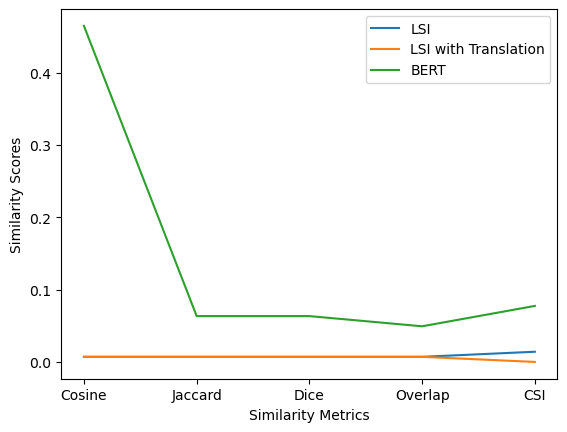

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
approaches = ['LSI', 'LSI with Translation', 'BERT']
metrics = ['Cosine', 'Jaccard', 'Dice', 'Overlap', 'CSI']
scores = np.array([[cosine_accuracy_lsi, jaccard_accuracy_lsi, dice_accuracy_lsi, overlap_accuracy_lsi, avg_sim_accuracy_lsi],
                   [cosine_accuracy_trans, jaccard_accuracy_trans, dice_accuracy_trans, overlap_accuracy_trans, avg_sim_accuracy_trans],
                   [cosine_accuracy_BERT, jaccard_accuracy_BERT, dice_accuracy_BERT, overlap_accuracy_BERT, avg_sim_accuracy_BERT]])

# Set up the plot
fig, ax = plt.subplots()

# Add the data to the plot
for i in range(len(approaches)):
    ax.plot(metrics, scores[i], label=approaches[i])

# Set the axis labels and legend
ax.set_xlabel('Similarity Metrics')
ax.set_ylabel('Similarity Scores')
ax.legend()

# Display the plot
plt.show()

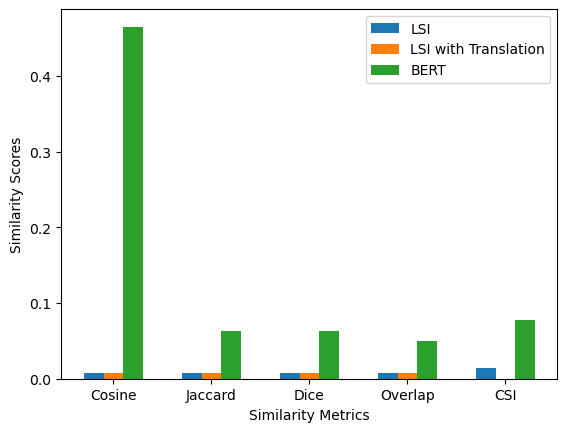

In [34]:
# Set up the plot
fig, ax = plt.subplots()

# Add the data to the plot
bar_width = 0.2
x_positions = np.arange(len(metrics))
for i in range(len(approaches)):
    ax.bar(x_positions + i*bar_width, scores[i], bar_width, label=approaches[i])

# Set the x-tick labels
ax.set_xticks(x_positions + bar_width)
ax.set_xticklabels(metrics)

# Set the axis labels and legend
ax.set_xlabel('Similarity Metrics')
ax.set_ylabel('Similarity Scores')
ax.legend()

# Display the plot
plt.show()